# Reinforcement Learning: Snake mit Deep Q-Network (DQN)
Dieses Notebook zeigt die Anwendung von DQN auf das Snake-Spiel mit erweiterten Zustandsmerkmalen.

In [2]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from tqdm import trange
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pygame

## 🐍 Snake-Umgebung
Enthält Spiellogik, Zustandsberechnung und Rendering mit Pygame.

In [3]:
import pygame
import random
import numpy as np

BLOCK_SIZE = 20
GRID_SIZE = 20
WIDTH = HEIGHT = BLOCK_SIZE * GRID_SIZE

# Farben
WHITE = (255, 255, 255)
GREEN = (0, 255, 0)
RED = (255, 0, 0)
BLACK = (0, 0, 0)

class SnakeGame:
    def __init__(self):
        pygame.init()
        self.display = pygame.display.set_mode((WIDTH, HEIGHT))
        pygame.display.set_caption("Snake")
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        self.direction = (1, 0)
        self.head = [GRID_SIZE // 2, GRID_SIZE // 2]
        self.snake = [self.head[:], [self.head[0] - 1, self.head[1]], [self.head[0] - 2, self.head[1]]]
        self.score = 0
        self.food = self.place_food()
        self.frame_iteration = 0
        return self.get_state()

    def place_food(self):
        while True:
            x = random.randint(0, GRID_SIZE - 1)
            y = random.randint(0, GRID_SIZE - 1)
            if [x, y] not in self.snake:
                return [x, y]

    def step(self, action):
        self.frame_iteration += 1

        # Richtungsänderung
        clock_wise = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        idx = clock_wise.index(self.direction)

        if action == 0:  # geradeaus
            new_dir = self.direction
        elif action == 1:  # rechts
            new_dir = clock_wise[(idx + 1) % 4]
        else:  # links
            new_dir = clock_wise[(idx - 1) % 4]

        self.direction = new_dir
        x, y = self.head
        dx, dy = self.direction
        self.head = [x + dx, y + dy]
        self.snake.insert(0, self.head[:])

        reward = -0.05
        done = False

        ate_food = self.head == self.food

        if ate_food:
            self.score += 1
            reward = 1.0
            self.food = self.place_food()
        else:
            self.snake.pop()

        if (self.head in self.snake[1:] or
            self.head[0] < 0 or self.head[0] >= GRID_SIZE or
            self.head[1] < 0 or self.head[1] >= GRID_SIZE):
            done = True
            reward = -1.0
            return self.get_state(), reward, done, {}

        old_dist = np.linalg.norm(np.array(self.snake[1]) - np.array(self.food))
        new_dist = np.linalg.norm(np.array(self.head) - np.array(self.food))

        if new_dist < old_dist:
            reward += 0.1
        else:
            reward -= 0.1

        def free_space(direction, max_depth=4):
            x, y = self.head
            dx, dy = direction
            count = 0
            for i in range(1, max_depth + 1):
                nx, ny = x + dx * i, y + dy * i
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and [nx, ny] not in self.snake:
                    count += 1
                else:
                    break
            return count / max_depth

        forward_dir = self.direction
        free_ahead = free_space(forward_dir)
        if free_ahead < 0.25:
            reward -= 0.3

        return self.get_state(), reward, done, {}

    def render(self):
        self.display.fill(BLACK)
        for part in self.snake:
            pygame.draw.rect(self.display, GREEN, pygame.Rect(part[0] * BLOCK_SIZE, part[1] * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
        pygame.draw.rect(self.display, RED, pygame.Rect(self.food[0] * BLOCK_SIZE, self.food[1] * BLOCK_SIZE, BLOCK_SIZE, BLOCK_SIZE))
        pygame.display.flip()
        self.clock.tick(10)

    def get_state(self):
        head_x, head_y = self.head
        dir_x, dir_y = self.direction

        def danger_at(pos):
            return (
                pos in self.snake or
                pos[0] < 0 or pos[0] >= GRID_SIZE or
                pos[1] < 0 or pos[1] >= GRID_SIZE
            )

        left = (-dir_y, dir_x)
        right = (dir_y, -dir_x)
        front = (dir_x, dir_y)

        front_block = [head_x + front[0], head_y + front[1]]
        right_block = [head_x + right[0], head_y + right[1]]
        left_block = [head_x + left[0], head_y + left[1]]

        danger_straight = danger_at(front_block)
        danger_right = danger_at(right_block)
        danger_left = danger_at(left_block)

        dir_up = dir_y == -1
        dir_down = dir_y == 1
        dir_left = dir_x == -1
        dir_right = dir_x == 1

        food_left = self.food[0] < head_x
        food_right = self.food[0] > head_x
        food_up = self.food[1] < head_y
        food_down = self.food[1] > head_y

        snake_length = len(self.snake) / (GRID_SIZE * GRID_SIZE)
        tail = self.snake[-1]
        dist_to_tail = np.linalg.norm(np.array(self.head) - np.array(tail)) / np.sqrt(GRID_SIZE**2 * 2)

        def free_space(direction, max_depth=5):
            x, y = head_x, head_y
            dx, dy = direction
            count = 0
            for i in range(1, max_depth + 1):
                nx, ny = x + dx * i, y + dy * i
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and [nx, ny] not in self.snake:
                    count += 1
                else:
                    break
            return count / max_depth

        free_straight = free_space(front)
        free_left = free_space(left)
        free_right = free_space(right)

        reachable_area = self.flood_fill_area(self.head)

        state = [
            int(danger_straight),
            int(danger_right),
            int(danger_left),

            int(dir_left),
            int(dir_right),
            int(dir_up),
            int(dir_down),

            int(food_left),
            int(food_right),
            int(food_up),
            int(food_down),

            snake_length,
            dist_to_tail,
            free_straight,
            free_left,
            free_right,
            reachable_area  # 🆕 hinzugefügt
        ]

        return np.array(state, dtype=float)

    def flood_fill_area(self, start_pos, max_depth=100):
        visited = set()
        queue = [tuple(start_pos)]
        area = 0

        while queue and area < max_depth:
            x, y = queue.pop(0)
            if (x, y) in visited:
                continue
            if x < 0 or x >= GRID_SIZE or y < 0 or y >= GRID_SIZE:
                continue
            if [x, y] in self.snake:
                continue

            visited.add((x, y))
            area += 1

            queue.append((x + 1, y))
            queue.append((x - 1, y))
            queue.append((x, y + 1))
            queue.append((x, y - 1))

        return area / (GRID_SIZE * GRID_SIZE)

## 🤖 DQN-Agent
Besteht aus einem neuronalen Netzwerk, einem Target-Net, Replay-Memory und Trainingslogik.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

class DQN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class DQNAgent:
    def __init__(
        self,
        state_dim=17,
        action_dim=3,
        hidden_dim=256,
        lr=0.0003,
        gamma=0.9,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
        memory_size=50000,
        batch_size=64,
        update_target_every=100
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.update_target_every = update_target_every
        self.train_step_count = 0

        # Q-Netzwerke
        self.model = DQN(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_model = DQN(state_dim, hidden_dim, action_dim).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=memory_size)

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return int(torch.argmax(q_values))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states_tensor = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions_tensor = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(self.device)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones_tensor = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.model(states_tensor).gather(1, actions_tensor)

        with torch.no_grad():
            next_q_values = self.target_model(next_states_tensor).max(1)[0].unsqueeze(1)
            target_q_values = rewards_tensor + (1 - dones_tensor) * self.gamma * next_q_values

        loss = self.loss_fn(q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.train_step_count += 1
        if self.train_step_count % self.update_target_every == 0:
            self.update_target_network()

        # Epsilon reduzieren
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def save_model(self, path="model.pth"):
        torch.save(self.model.state_dict(), path)

    def load_model(self, path="model.pth"):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.eval()

## 🧠 Training
Trainiere den DQN-Agenten über 10.000 Episoden. Der Verlauf wird visualisiert.

Training: 100%|██████████| 50/50 [00:53<00:00,  1.07s/it]


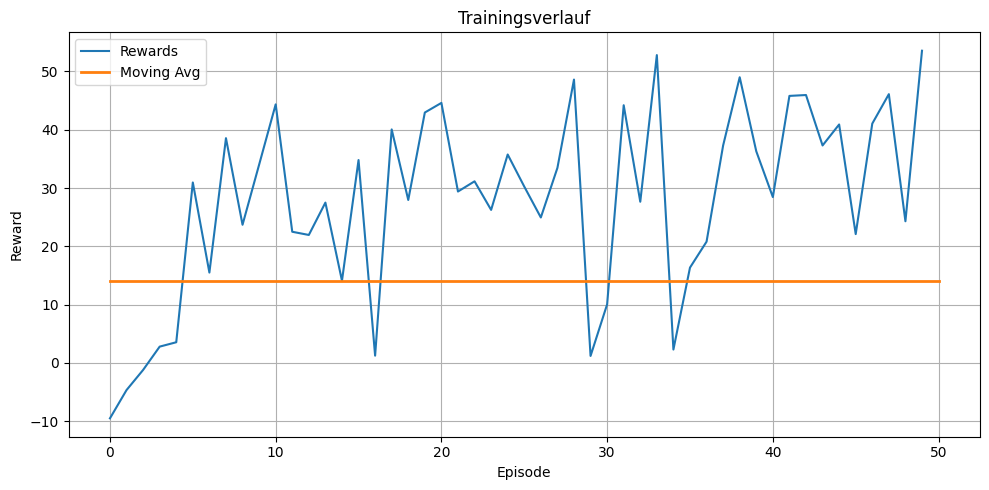

In [8]:
EPISODES = 50
MAX_STEPS = 500
PLOT_EVERY = 200

env = SnakeGame()
agent = DQNAgent()
scores = []

for episode in trange(EPISODES, desc="Training"):
    state = env.reset()
    total_reward = 0

    for _ in range(MAX_STEPS):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        agent.train_step()
        state = next_state
        total_reward += reward
        if done:
            break

    scores.append(total_reward)

    if (episode + 1) % PLOT_EVERY == 0:
        avg = np.mean(scores[-PLOT_EVERY:])
        print(f"📈 Episode {episode+1}, Ø Reward: {avg:.2f}")

# Plot
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode="valid")

plt.figure(figsize=(10, 5))
plt.plot(scores, label="Rewards")
plt.plot(moving_average(scores), label="Moving Avg", linewidth=2)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Trainingsverlauf")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 💾 Modell speichern
Das trainierte Modell wird zur späteren Verwendung gesichert.

In [9]:
agent.save_model("model.pth")
print("Modell gespeichert.")

Modell gespeichert.


## 📊 Evaluation
Bewertung des trainierten Agenten über 50 Testspiele (ε = 0).

🏁 Episode 1 Score: 60.24999999999929
🏁 Episode 2 Score: 34.65000000000003
🏁 Episode 3 Score: 40.399999999999864
🏁 Episode 4 Score: 47.69999999999965
🏁 Episode 5 Score: 38.19999999999991
🏁 Episode 6 Score: 49.549999999999685
🏁 Episode 7 Score: 38.64999999999986
🏁 Episode 8 Score: 58.34999999999925
🏁 Episode 9 Score: 31.500000000000135
🏁 Episode 10 Score: 55.7999999999996
🏁 Episode 11 Score: 41.5499999999998
🏁 Episode 12 Score: 44.34999999999986
🏁 Episode 13 Score: 61.8999999999994
🏁 Episode 14 Score: 27.600000000000172
🏁 Episode 15 Score: 59.09999999999934
🏁 Episode 16 Score: 43.4999999999998
🏁 Episode 17 Score: 44.69999999999985
🏁 Episode 18 Score: 61.69999999999922
🏁 Episode 19 Score: 25.300000000000118
🏁 Episode 20 Score: 48.699999999999555
🏁 Episode 21 Score: 37.99999999999995
🏁 Episode 22 Score: 38.649999999999956
🏁 Episode 23 Score: 37.69999999999983
🏁 Episode 24 Score: 18.80000000000006
🏁 Episode 25 Score: 38.949999999999825
🏁 Episode 26 Score: 45.899999999999636
🏁 Episode 27 Sco

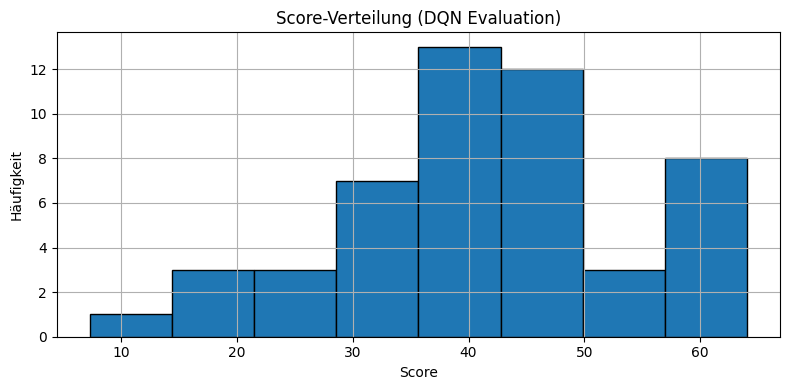

Durchschnittlicher Score: 41.77
Maximaler Score: 64.0499999999993


In [10]:
NUM_EPISODES = 50
agent.epsilon = 0
scores = []

for episode in range(1, NUM_EPISODES + 1):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        total_reward += reward

    scores.append(total_reward)
    print(f"🏁 Episode {episode} Score: {total_reward}")

# Plot
plt.figure(figsize=(8, 4))
plt.hist(scores, bins='auto', edgecolor="black")
plt.title("Score-Verteilung (DQN Evaluation)")
plt.xlabel("Score")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Durchschnittlicher Score: {np.mean(scores):.2f}")
print(f"Maximaler Score: {np.max(scores)}")

## 🎮 Live-Spiel
Zeigt den Agenten beim Spielen in der Pygame-Oberfläche.

In [11]:
agent.epsilon = 0
NUM_GAMES = 3

for i in range(1, NUM_GAMES + 1):
    state = env.reset()
    done = False
    score = 0
    print(f"\n🎮 Spiel {i} startet...")

    while not done:
        action = agent.choose_action(state)
        state, reward, done, _ = env.step(action)
        score += reward
        env.render()
        time.sleep(0.1)

    print(f"🏁 Spiel {i} beendet. Score: {score}")
    time.sleep(1)


🎮 Spiel 1 startet...


: 